# Bidirectional LSTM Model of Price Trend Classifier
----------------
使用 Tensorflow 建立 Bidirectional LSTM model 用於判斷股價處於何種趨勢中。目的是將訓練完成的模型用於自動標記其他股價趨勢。

## 使用模組
--------------


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from tensorflow.contrib import rnn
from matplotlib_labels_color_plot import plot_multicolored_lines # Customized module

## 資料匯入及預處理
------------
蒐集鴻海(2317)股票的分鐘開盤價格，期間從 2018-02-22 至 2018-03-21 ，一共 5054 筆資料，並以人工方式判斷各資料點價格之趨勢，將其分為上升、持平、下跌三種趨勢，作為模型訓練標籤。

In [2]:
data = pd.read_excel('2317.xls')
data[['Open','Trend']].head(5)

,Open,Trend
2018-02-22 09:00:00,87.8,1
2018-02-22 09:01:00,87.9,1
2018-02-22 09:02:00,87.9,1
2018-02-22 09:03:00,87.8,1
2018-02-22 09:04:00,87.8,1


In [3]:
price = data['Open']
trend = data['Trend']
price = price.astype('float32') # original type is float64
print('price.shape:',price.shape)
print('trend.shape:',trend.shape)

price.shape: (5054,)
trend.shape: (5054,)


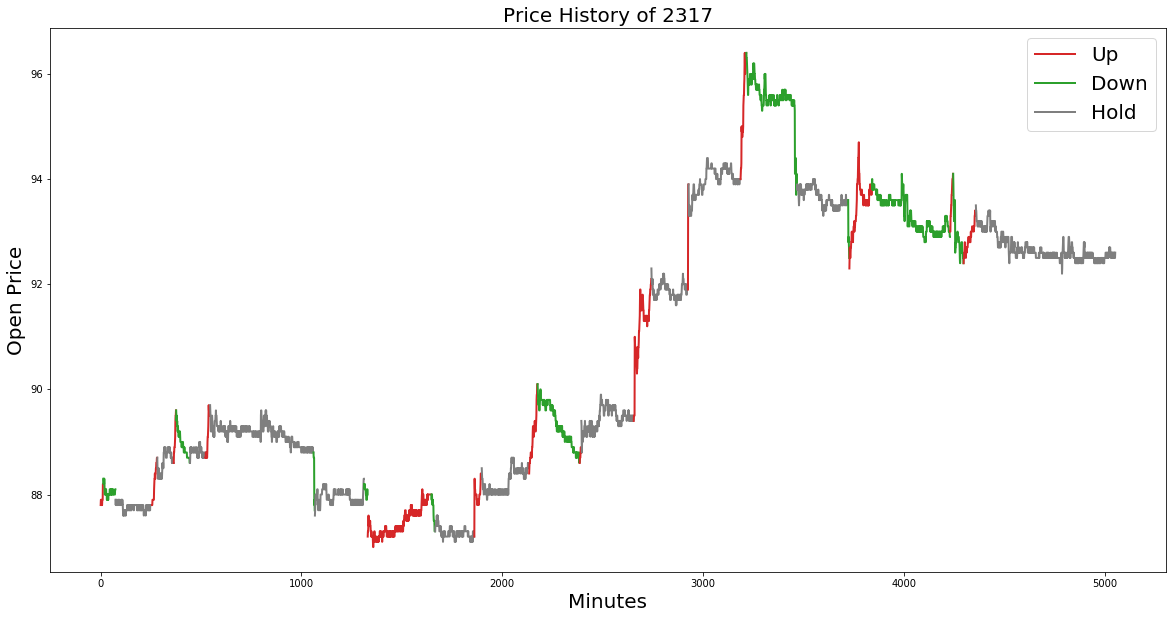

In [4]:
# Plot original data
color_dict = {1:'tab:red', 0:'tab:gray', -1:'tab:green'}
plot_multicolored_lines(x=range(len(price)), y=price, colors=trend.map(color_dict))
plt.legend(['Up','Down','Hold'], fontsize=20)
plt.title('Price History of 2317', fontsize=20)
plt.xlabel('Minutes', fontsize=20)
plt.ylabel('Open Price', fontsize=20)
plt.show()

In [5]:
# Descriptive statistics of Price
print('價格之敘述性統計量：')
print(price.describe())

價格之敘述性統計量：
count    5054.000000
mean       90.756798
std         2.595871
min        87.000000
25%        88.400002
50%        89.599998
75%        93.099998
max        96.400002
Name: Open, dtype: float64


In [6]:
# Count the number of occurrences of each Trend
trend_dict = {1:'Up', 0:'Hold', -1:'Down'}
print('統計各趨勢發生次數：')
print(trend.map(trend_dict).value_counts())

統計各趨勢發生次數：
Hold    3183
Down    1084
Up       787
Name: Trend, dtype: int64


持平發生的次數最多，佔整體資料的 63%，因此若全猜測持平也會有 63% 的準確率，所以模型的準確率要大於 63% 才具有參考價值。

### 價格資料預處理
------------------------------------------------
原始價格資料的範圍大約是在 87 到 96 左右，要將資料轉換為在 -1 到 1 之間，否則會使機器學習的收斂速度減慢，有試過取自然對數、差分、取自然對數後再差分等方式，最後發現取對數後再利用 sklearn.preprocessing.minmax_scale 將資料壓縮在 0 到 1 之間是較有效的方式。

壓縮後價格之敘述統計量：
count    5054.000000
mean        0.408075
std         0.278035
min         0.000000
25%         0.155598
50%         0.287010
75%         0.660500
max         1.000000
dtype: float64


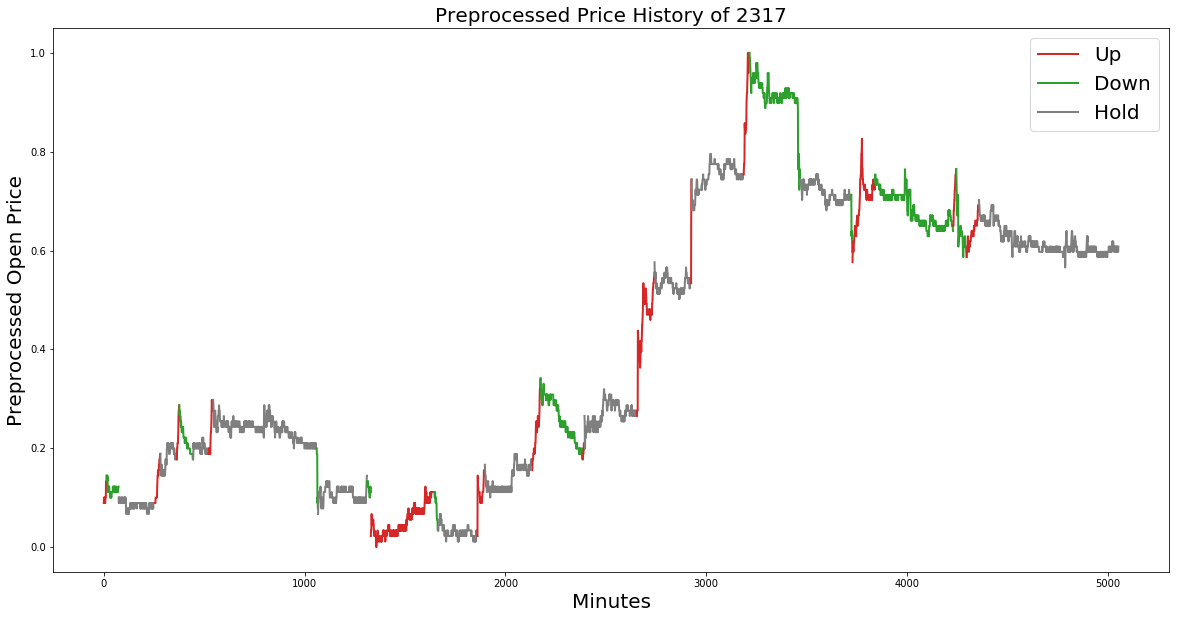

In [7]:
# Preprocess Price data
ln_price = np.log(price)
#input_x = np.log(price).diff().replace(np.NaN,0)
#input_x = np.log(price) 
#input_x = pd.Series(minmax_scale(ln_price)).diff().replace(np.NaN, 0)
input_x = minmax_scale(ln_price)

print('壓縮後價格之敘述統計量：')
print(pd.Series(input_x).describe())

# Plot preprocessed Price data
color_dict = {1:'tab:red', 0:'tab:gray', -1:'tab:green'}
plot_multicolored_lines(x=range(len(input_x)), y=input_x, colors=trend.map(color_dict))
plt.legend(['Up','Down','Hold'], fontsize=20)
plt.title('Preprocessed Price History of 2317', fontsize=20)
plt.xlabel('Minutes', fontsize=20)
plt.ylabel('Preprocessed Open Price', fontsize=20)
plt.show()

可以看到預處理過後的價格資料與處理前的資料形狀及趨勢大致相同，僅有 Y 軸刻度從 87 至 96 壓縮至 0.0 至 1.0

### 趨勢標籤資料預處理
-----------------------
 - 原始資料以 -1 表示下跌、 0 表示持平、 1 表示上升
 - 這邊改為：  0 表示下跌、 1 表示持平、 2 表示上升

In [8]:
# Preprocess Trend data
code_dict = {-1:0, 0:1, 1:2}
input_y = trend.map(code_dict)
print('input_x.shape:',input_x.shape)
print('input_y.shape:',input_y.shape)

input_x.shape: (5054,)
input_y.shape: (5054,)


## 建立 Bidirectional LSTM model
------------------------------------
此模型是利用資料點前後約2個小時來判斷該資料點是處於何種趨勢之中，用 Forward LSTM Cells 來捕捉資料點前2個小時的資訊，用 Backward LSTM Cells 來捕捉資料點後2個小時的資訊，之後只匯入該資料點的結果，模型結構圖如下：
![Structure_of_Bidirectional_LSTM_model_of_Price_Classifier](https://sites.google.com/site/xliuforliu/home/Structure_of_Bidirectional_LSTM_model_of_Price_Classifier.JPG)

### Hyperparameters

In [15]:
# Training Parameters
LEARNING_RATE = 0.001
TRAINING_STEPS = 50000
BATCH_SIZE = 256
TEST_SIZE = 500
DISPLAY_STEPS = 500
SAVE_STEPS = 5000

# Neural Network Parameters
NUM_INPUT = 1 # number of features
TIMESTEPS = 256 # length of an input data
HALF_TIMESTEPS = TIMESTEPS//2 # 128
NUM_HIDDENS = 256 # number of hidden layers
NUM_CLASSES = 3 # total classes (0-2 digits)

# TensorBoard and checkpoint Parameters
LOGDIR = '/tensorboard_tmp/bidirectional_lstm_classifier/'
NUMBERING = '20180328_03'

將輸入的資料分割成 TIMESTEPS=256 為一筆的 sliding window 資料，並且以 Trend 在 HALF_TIMESTEPS=128 作為該筆資料的標籤，

例如：
- 第1筆資料為 $X_{1}$, $X_{2}$, $X_{3}$, … , $X_{254}$, $X_{255}$, $X_{256}$，標籤就為 $Y_{128}$ 

- 第2筆資料為 $X_{2}$, $X_{3}$, $X_{4}$, … , $X_{255}$, $X_{256}$, $X_{257}$，標籤就為 $Y_{129}$

另外強調本模型的目的不在於預測未來的趨勢，而是用來判斷並標記過去資料的趨勢，用於未來模型的建立，因此本模型是以大約前後兩個小時來判斷該時間點的趨勢。

In [16]:
# Transform Price data into sliding window form
temp_x = tf.convert_to_tensor(input_x)
x = tf.map_fn(lambda i: temp_x[i:i+TIMESTEPS], tf.range(len(input_x)-TIMESTEPS+1), dtype=tf.float32)

# Transform Trend data into One_hot labels data, ex. 0->[1, 0, 0]   1->[0, 1, 0]  2->[0, 0, 1]
y = tf.one_hot(input_y[HALF_TIMESTEPS-1 : -HALF_TIMESTEPS], depth=NUM_CLASSES, dtype=tf.int32)

# Inspect sliding window form data
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x, y = sess.run([x, y])
    print('檢查sliding window資料維度')
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
    print('x: \n', x)
    print('y:\n', y)

檢查sliding window資料維度
x.shape: (4799, 256)
y.shape: (4799, 3)
x: 
 [[0.08921432 0.10030746 0.10030746 ... 0.08921432 0.08921432 0.08921432]
 [0.10030746 0.10030746 0.08921432 ... 0.08921432 0.08921432 0.08921432]
 [0.10030746 0.08921432 0.08921432 ... 0.08921432 0.08921432 0.08921432]
 ...
 [0.62903976 0.60801315 0.60801315 ... 0.60801315 0.60801315 0.60801315]
 [0.60801315 0.60801315 0.60801315 ... 0.60801315 0.60801315 0.5974808 ]
 [0.60801315 0.60801315 0.60801315 ... 0.60801315 0.5974808  0.60801315]]
y:
 [[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


### 建立 Data Set 並分割為 Training Set 與 Test Set
-----------------------
經過 sliding window 處理過後的資料共有 4799 筆，匯入 Tensorflow dataset 後隨機排序，因為資料中的趨勢是一段一段的，隨機排序後可以防止某些 batch 完全只有持平或是上升的單一趨勢情形。

然後分割 dataset 為 Training Set(4299筆) 與 Test Set(500筆)

In [11]:
# Create Dataset iterator

# Import data to Tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(1000)

# Create Training dataset
train_set = dataset.skip(TEST_SIZE)
train_set = train_set.repeat(-1)
train_set = train_set.batch(BATCH_SIZE)
iterator = train_set.make_one_shot_iterator()
next_batch = iterator.get_next()

# Create Test dataset
test_set = dataset.take(TEST_SIZE)
test_set = test_set.repeat(-1)
test_set = test_set.batch(TEST_SIZE)
test_iterator = test_set.make_one_shot_iterator()
pop_all_test_set = test_iterator.get_next()

### Bidirectional LSTM Layer

In [12]:
def bidirectional_rnn_layer(inputx, num_hiddens, num_classes, name='bi_lstm'):
    with tf.name_scope(name):
        # Declare Variable Tensors
        w = tf.Variable(tf.random_normal([2*num_hiddens, num_classes]), dtype=tf.float32, name='W')
        b = tf.Variable(tf.random_normal([num_classes]), dtype=tf.float32, name='B')
        
        # Transform input to fit the bidirectional LSTM model
        x = tf.unstack(inputx, TIMESTEPS, 1)
        
        # Forward and backward LSTM cells
        lstm_fw_cell = rnn.BasicLSTMCell(num_hiddens, forget_bias=1.0)
        lstm_bw_cell = rnn.BasicLSTMCell(num_hiddens, forget_bias=1.0)
        
        # Combine forward and backward LSTM cells to bidirectional LSTM
        outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                                     dtype=tf.float32)
        
        # Record informations in TensorBoard
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        
        # Only use the result at HALF_TIMESTEPS to calculate logits
        return tf.matmul(outputs[HALF_TIMESTEPS], w) + b

### Loss and Accuracy Steps

In [13]:
X = tf.placeholder(tf.float32, [None, TIMESTEPS, NUM_INPUT], name='x')
Y = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='labels')
logits = bidirectional_rnn_layer(X, NUM_HIDDENS, NUM_CLASSES)
prediction = tf.nn.softmax(logits)

with tf.name_scope('loss'):
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                                logits=logits, labels=Y, name='loss'))
    tf.summary.scalar('loss', loss_op)

with tf.name_scope('train'):
    train_step  = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss_op)

with tf.name_scope('accuracy'):
    # Evaluate model (with test logits, for dropout to be disabled)
    correct_prediction  = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction , tf.float32))
    tf.summary.scalar('accuracy', accuracy)

summ = tf.summary.merge_all()
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
saver = tf.train.Saver()
writer = tf.summary.FileWriter(LOGDIR + NUMBERING)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Start Training

In [14]:
# Start training
with tf.Session() as sess:    
    # Run the initializer
        #saver.restore(sess, 'Saved_model/' + NUMBERING + '.ckpt')
    sess.run(init)

    writer.add_graph(sess.graph)
    
    for step in range(1, TRAINING_STEPS+1):
        batch_x, batch_y = sess.run(next_batch)        
        batch_x = batch_x.reshape((BATCH_SIZE, TIMESTEPS, NUM_INPUT))
        # Run optimization op (backprop)
        sess.run(train_step, feed_dict={X: batch_x, Y: batch_y})
        if step % DISPLAY_STEPS == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc, s = sess.run([loss_op, accuracy, summ], 
                                        feed_dict={X: batch_x, Y: batch_y})
            writer.add_summary(s, step)
            print('Step ' + str(step) + ', Minibatch Loss= ' + \
                  '{:.4f}'.format(loss) + ', Training Accuracy= ' + \
                  '{:.3f}'.format(acc))
            
        if step % SAVE_STEPS == 0:
            saver.save(sess, 'Saved_model/' + NUMBERING + '.ckpt')

    print('Optimization Finished!')
    
    # Test accuracy
    test_x, test_y = sess.run(pop_all_test_set)
    test_x = test_x.reshape((-1, TIMESTEPS, NUM_INPUT))
    test_acc, test_label, test_pred = sess.run([accuracy, tf.argmax(batch_y, 1), tf.argmax(prediction, 1)],
                                               feed_dict={X: test_x, Y: test_y})
    print('Test Accuracy:', test_acc)        

    # All data accuracy
    all_data = x.reshape((-1, TIMESTEPS, NUM_INPUT))
    all_label = y
    all_acc, all_label, all_pred = sess.run([accuracy, tf.argmax(batch_y, 1), tf.argmax(prediction, 1)],
                                            feed_dict={X: all_data, Y: all_label})
    print('All Dataset Accuracy:', all_acc)        

Step 1, Minibatch Loss= 0.8190, Training Accuracy= 0.664
Step 500, Minibatch Loss= 0.8165, Training Accuracy= 0.637
Step 1000, Minibatch Loss= 0.7807, Training Accuracy= 0.727
Step 1500, Minibatch Loss= 0.7928, Training Accuracy= 0.684
Step 2000, Minibatch Loss= 0.6612, Training Accuracy= 0.684
Step 2500, Minibatch Loss= 0.8060, Training Accuracy= 0.637
Step 3000, Minibatch Loss= 1.0644, Training Accuracy= 0.512
Step 3500, Minibatch Loss= 0.6541, Training Accuracy= 0.770
Step 4000, Minibatch Loss= 0.6803, Training Accuracy= 0.660
Step 4500, Minibatch Loss= 0.7481, Training Accuracy= 0.695
Step 5000, Minibatch Loss= 0.7868, Training Accuracy= 0.664
Step 5500, Minibatch Loss= 0.7035, Training Accuracy= 0.715
Step 6000, Minibatch Loss= 0.6469, Training Accuracy= 0.684
Step 6500, Minibatch Loss= 0.5987, Training Accuracy= 0.781
Step 7000, Minibatch Loss= 0.7126, Training Accuracy= 0.699
Step 7500, Minibatch Loss= 0.8107, Training Accuracy= 0.586
Step 8000, Minibatch Loss= 0.5893, Training 

### Accuracy of Minibatch
![accuracy](https://i.imgur.com/B3jOafx.png)

### Loss of Minibatch
![loss](https://i.imgur.com/kU1dkL0.png)

因為每次計算 Loss 和 Accuracy 時，是使用該次 Train batch set ，而不是固定的 Validation set ，所以可以看見模型的波動相當大，並且模型大概在運算 20,000 次之後才有開始學習的情形，大約在 45,000 次之後收斂，最後 Test set 的準確率有 93.4% 。

## Test set 分析結果

In [59]:
label_dict = {0:'Down', 1:'Hold', 2:'Up'}
test_y_cross = pd.Series(np.argmax(test_y,1)).map(label_dict)
print('Test Set中各趨勢發生次數：')
print(test_y_cross.value_counts())

Test Set中各趨勢發生次數：
Hold    395
Up       69
Down     36
dtype: int64


In [60]:
test_pred_cross = pd.Series(test_pred).map(label_dict)
print('Prediction中各趨勢發生次數：')
print(test_pred_cross.value_counts())

Prediction中各趨勢發生次數：
Hold    387
Up       78
Down     35
dtype: int64


In [67]:
print('預測值與實際值交叉次數比較表：')
pd.crosstab(test_y_cross, test_pred_cross, rownames=['Label'], colnames=['Prediction'])

預測值與實際值交叉次數比較表：


Prediction,Down,Hold,Up
Label,,,
Down,27,6,3
Hold,8,376,11
Up,0,5,64


In [68]:
print('各趨勢判斷正確率：')
pd.crosstab(test_y_cross, test_pred_cross, rownames=['Label'], colnames=['Prediction'], 
            normalize='index')

各趨勢預測正確率：


Prediction,Down,Hold,Up
Label,,,
Down,0.750000,0.166667,0.083333
Hold,0.020253,0.951899,0.027848
Up,0.000000,0.072464,0.927536


可以看見模型在判斷持平時表現最好，有 95.1% 的判斷正確率；其次為上升趨勢有 92.7% 的判斷正確率；而上跌的判斷最差，僅有 75.0% 的正確率。

In [71]:
print('各趨勢誤判率：')
pd.crosstab(test_y_cross, test_pred_cross, rownames=['Label'], colnames=['Prediction'], 
            normalize='columns')

各趨勢誤判率：


Prediction,Down,Hold,Up
Label,,,
Down,0.771429,0.015504,0.038462
Hold,0.228571,0.971576,0.141026
Up,0.000000,0.012920,0.820513


模型在判斷持平時的誤判率最低，僅有 2.84%(1.55%+1.29%)的誤判率；在判斷上升趨勢中則有 17.9% 的誤判率，其中有 3.8% 的機率會將下跌趨勢判斷成上升；判斷下跌趨勢則有 22.8% 的誤判率，但全是誤判成持平趨勢，沒有誤判成上升趨勢的情形。

## 未來方向
-------------------------
此模型還有修改空間，將來可以朝幾個方向修改：
1. 增加訓練的資料量
2. 加入指數衰減學習率
3. 增加 LSTM 隱藏結點數量或增加隱藏層
4. 以CNN模型處理類似問題

為了提高模型的實用性，未來應減少判斷趨勢時使用的時間長度，目前是使用前後2個小時，未來模型應減少至1個小時或更短。